In [59]:
import os
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from PIL import Image
import cv2
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.image as mImg
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [60]:
test_path = './test'
ann_path = './result'

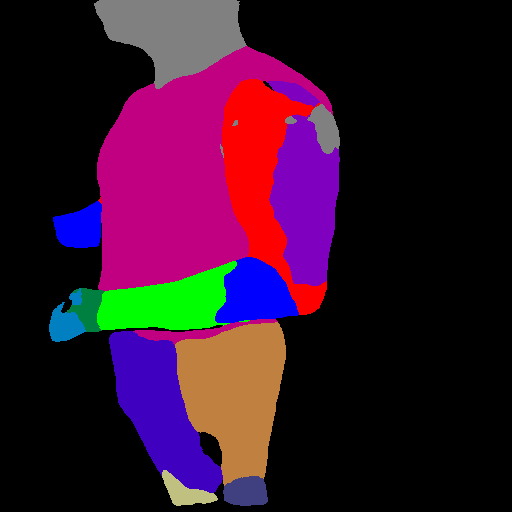

(287, (512, 512))

In [62]:
import random
randnum = random.randint(0, 399)
image_sample = Image.open(os.path.join(ann_path, str(randnum).zfill(4)+'.png'))
image_sample.show()
randnum, image_sample.size

In [54]:
# 1 x 65536 -> 256 x 256
# list to image
# 그런데 result는 이미 image기 때문에 쓸 필요 없을듯..?
def decode(rle_mask):
    mask = rle_mask.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)

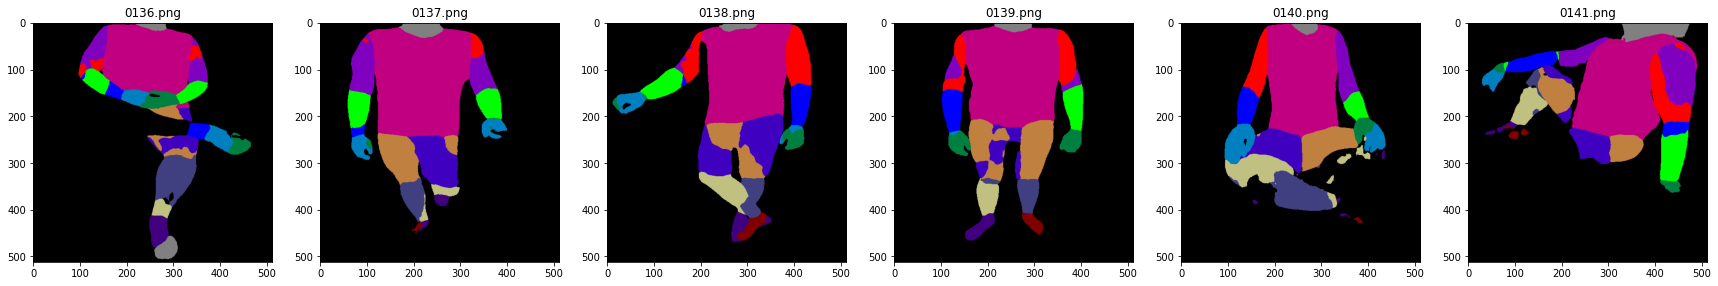

In [58]:
"""
reading and decoding the submission 

"""

i = 0
j = random.randint(0, 394)
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..

# Visualizing the predicted outputs
for k in range(6):
    plt.subplot(1, 6, k+1)
    readImg = mImg.imread(os.path.join(ann_path, str(j+k).zfill(4)+'.png'))
    plt.imshow(readImg)
    plt.title(str(j+k).zfill(4)+'.png')


In [14]:
"""
Function which returns the labelled image after applying CRF

"""
# Original_image = Image which has to labelled
# Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    # print(original_image)
    original_image = cv2.resize(original_image, (512, 512))
    # print(original_image)
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 15
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(10,10), srgb=(70,70,70), rgbim=original_image, compat=5)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

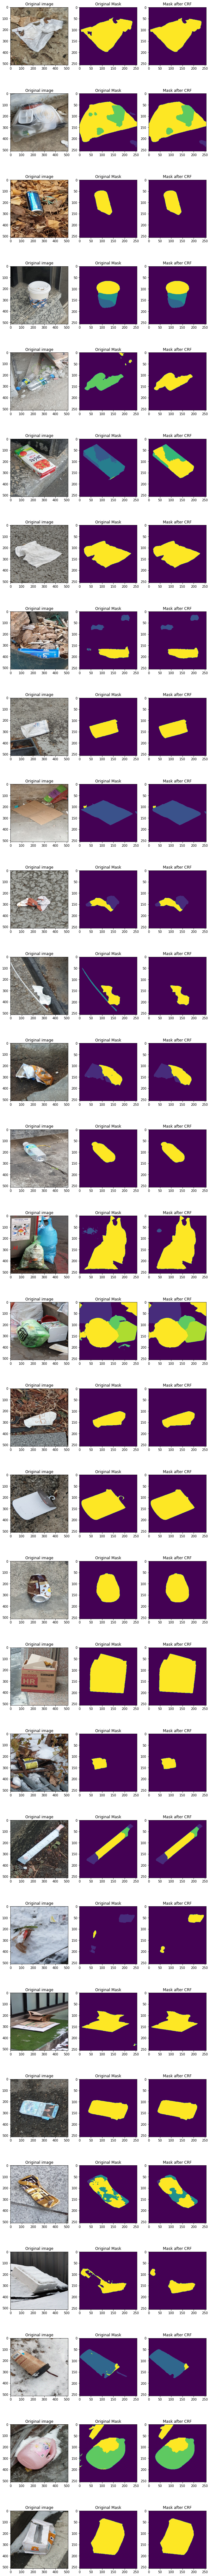

In [21]:
"""
visualizing the effect of applying CRF

"""
nImgs = 30
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,150))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..

for k in range(10):
    decoded_mask = 




while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString']) # 1 x 65536 -> 256 x 256       
        orig_img = imread(test_path+df.loc[i,'image_id']) # 512 x 512 x 3
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    # print(j)
    i = i + 1

In [22]:
"""
used for converting the decoded image to rle mask

"""
def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [23]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

100%|██████████| 819/819 [14:23<00:00,  1.05s/it]


In [24]:
df.to_csv('./submission/crf_' + target_csv, index=False)